# Importing Libraries

In [1]:
# Develop a hand gesture recognition model that can accurately identify and classify different hand gestures from image or video data, enabling intuitive human-computer interaction and gesture-based control systems.
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm
import random as rn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau

# Exploring the data

In [2]:
lookup = {}
reverselookup = {}
count = 0

base_path = 'C:/Users/NAVEENA/Downloads/archive 1/leapGestRecog/'

for gesture in os.listdir(os.path.join(base_path, '00')):
    if not gesture.startswith('.'):
        lookup[gesture] = count
        reverselookup[count] = gesture
        count += 1

print(lookup)

{'01_palm': 0, '02_l': 1, '03_fist': 2, '04_fist_moved': 3, '05_thumb': 4, '06_index': 5, '07_ok': 6, '08_palm_moved': 7, '09_c': 8, '10_down': 9}


# Preprocess Data

In [3]:
x_data = []
y_data = []
IMG_SIZE = 150
datacount = 0

base_path = r"C:\Users\NAVEENA\Downloads\archive 1\leapGestRecog"

for i in range(10):  # Folders named 00, 01, ..., 09
    folder_path = os.path.join(base_path, f"0{i}")
    for gesture_name in os.listdir(folder_path):
        if not gesture_name.startswith('.'):
            gesture_path = os.path.join(folder_path, gesture_name)
            count = 0
            for img_file in os.listdir(gesture_path):
                img_path = os.path.join(gesture_path, img_file)
                try:
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    arr = np.array(img)
                    x_data.append(arr)
                    count += 1
                except Exception as e:
                    print(f"Error reading image: {img_path}, skipping. Error: {e}")
            y_values = np.full((count, 1), lookup[gesture_name])
            y_data.append(y_values)
            datacount += count

x_data = np.array(x_data, dtype='float32')
y_data = np.vstack(y_data)  # Use vstack to flatten the list of arrays
y_data = y_data.reshape(datacount, 1)

print(f"Loaded {datacount} images.")

Loaded 20000 images.


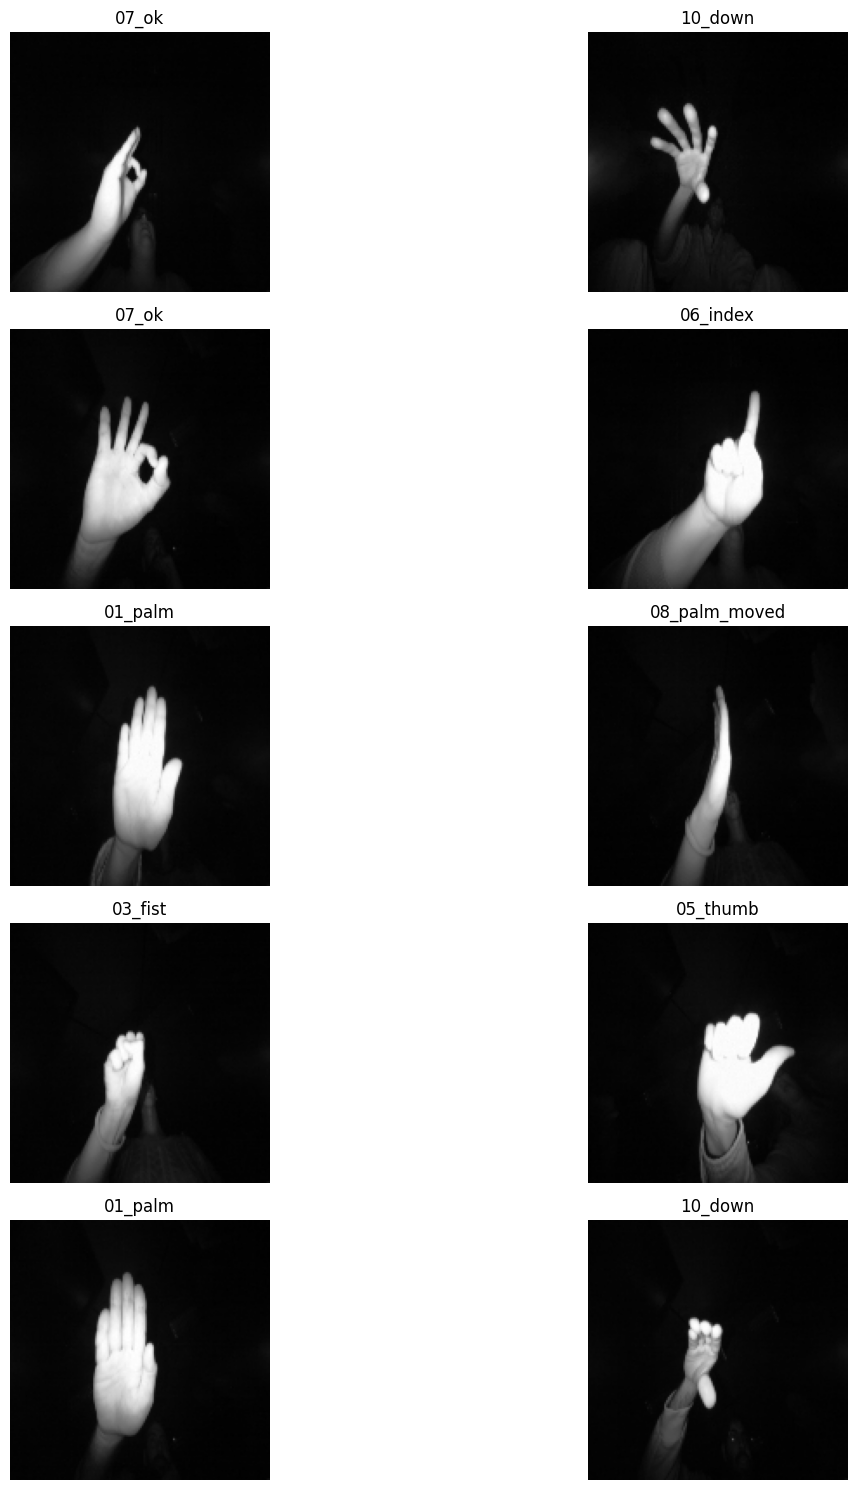

In [4]:
fig, ax = plt.subplots(5, 2)
fig.set_size_inches(15, 15)

for i in range(5):
    for j in range(2):
        l = rn.randint(0, len(y_data) - 1)
        ax[i, j].imshow(x_data[l], cmap='gray')
        ax[i, j].set_title(reverselookup[int(y_data[l, 0])])
        ax[i, j].axis('off')  # Optional: remove axes for cleaner display

plt.tight_layout()
plt.show()

In [5]:
x_data = x_data.reshape((datacount, IMG_SIZE, IMG_SIZE, 1))
x_data = x_data / 255.0  
y_data = to_categorical(y_data)

In [6]:
x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.25,random_state=42)

# Build CNN Model

In [7]:
num_classes = y_train.shape[1] 

In [8]:
model = Sequential([
    Input(shape=(150, 150, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [9]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
checkpoint = ModelCheckpoint('./best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=30, verbose=1)
tensorboard = TensorBoard(log_dir='./logs')
csvlogger = CSVLogger("training_log.csv")
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

callbacks = [checkpoint, earlystop, tensorboard, csvlogger, reduce_lr]

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      10,616,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,637,066 (40.58 MB)

 Trainable params: 10,637,066 (40.58 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
print(x_test.shape)

(5000, 150, 150, 1)


# Train the Model

In [13]:
callbacks = [
    ModelCheckpoint('./best_model.keras', save_best_only=True)
]

In [14]:
history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=10,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 143s 359ms/step - accuracy: 0.7863 - loss: 0.6632 - val_accuracy: 0.9977 - val_loss: 0.0116
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 130s 346ms/step - accuracy: 0.9982 - loss: 0.0076 - val_accuracy: 0.9983 - val_loss: 0.0052
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 126s 336ms/step - accuracy: 0.9962 - loss: 0.0150 - val_accuracy: 0.9980 - val_loss: 0.0060
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 133s 355ms/step - accuracy: 0.9980 - loss: 0.0055 - val_accuracy: 0.9997 - val_loss: 8.9903e-04
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 132s 353ms/step - accuracy: 1.0000 - loss: 1.3265e-04 - val_accuracy: 0.9993 - val_loss: 8.7175e-04
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 131s 348ms/step - accuracy: 1.0000 - loss: 2.4805e-05 - val_accuracy: 0.9993 - val_loss: 9.1783e-04
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 126s 335ms/step - accuracy: 1.0000 - loss: 1.6779e-05 - val_accuracy: 0.9993 - val_loss: 0.0010
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 132s 351ms/s

# Visualize Training

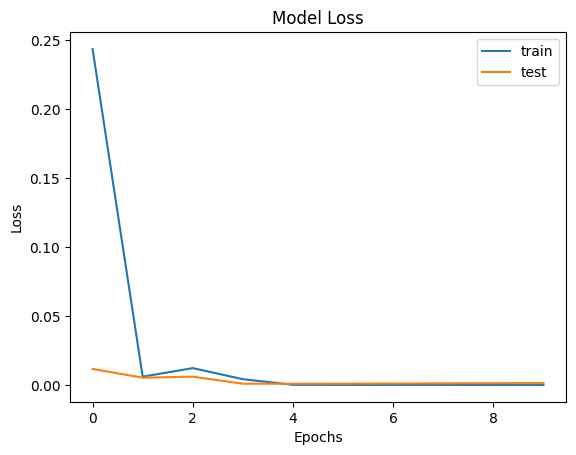

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

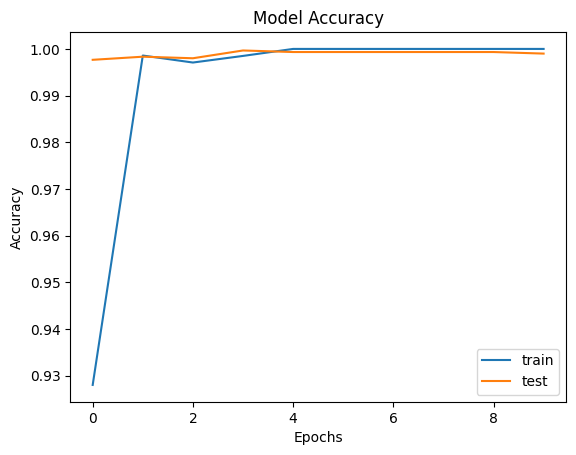

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

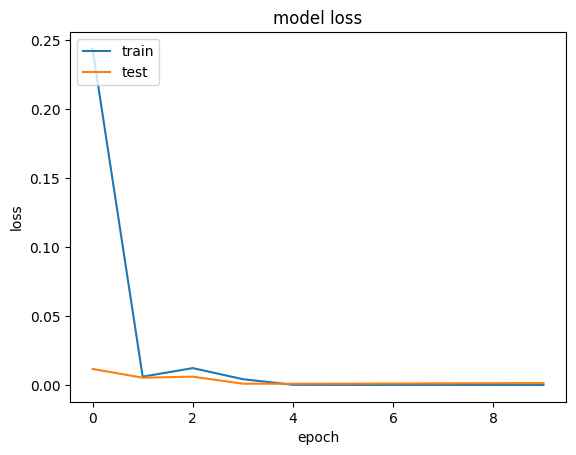

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

print('Test accuracy: {:2.2f}%'.format(test_accuracy * 100))

Test accuracy: 99.94%


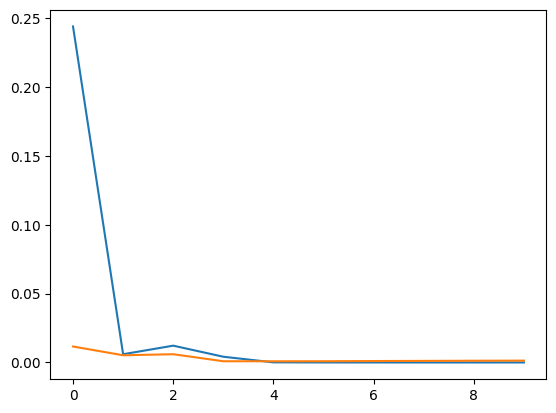

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

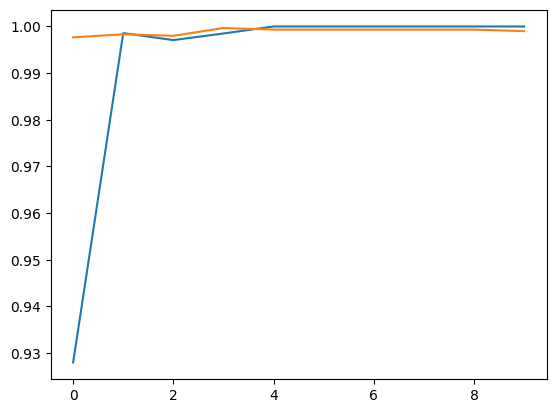

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [24]:
train_loss, train_acc = model.evaluate(x_train, y_train)
test_loss, test_acc = model.evaluate(x_test, y_test)

469/469 ━━━━━━━━━━━━━━━━━━━━ 48s 103ms/step - accuracy: 1.0000 - loss: 2.5881e-05
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.9994 - loss: 0.0017


In [25]:
pred_train= model.predict(x_train)
scores = model.evaluate(x_train, y_train, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   

pred_test= model.predict(x_test)
scores2 = model.evaluate(x_test, y_test, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))  

469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 89ms/step
Accuracy on training data: 0.9998000264167786% 
 Error on training data: 0.00019997358322143555
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step
Accuracy on test data: 0.9994000196456909% 
 Error on test data: 0.000599980354309082
